<a href="https://colab.research.google.com/github/shnehapaudyal/Socialmediaanalytics/blob/main/Socialmediaanalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installation

In [ ]:
!pip install praw
!pip install pandas matplotlib
!pip install wordcloud
!pip install gensim

!pip install praw pandas matplotlib wordcloud gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 1.5 MB/s eta 0:00:00


Import

In [ ]:
from google.colab import drive
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
import re
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
from gensim import corpora, models
from pprint import pprint
from collections import Counter
from nltk import bigrams, trigrams, word_tokenize
from nltk.util import ngrams
from collections import Counter
from textblob import TextBlob

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
SECRET = 'Secretkey'
APP_ID = 'ID'

reddit = praw.Reddit (
    client_id = APP_ID,
    client_secret = SECRET,
    user_agent = 'Comment Extraction'
)

In [ ]:
def search_comments(submission):
  result = []

  comments = submission.comments
  comments.replace_more(limit = 0)

  for comment in comments.list():
    if isinstance(comment, MoreComments):
      print('Obtained more comments')
      continue

    # Convert Unix timestamp to a datetime object
    comment_date = datetime.datetime.utcfromtimestamp(comment.created_utc)
    # formating the datetime object to a string, e.g., YYYY-MM-DD
    formatted_date = comment_date.strftime('%Y-%m-%d')
    formatted_date

    row = {"body": comment.body,
          "n_words": len(comment.body.split()),
          "comment_date": formatted_date,
          "upvotes": comment.score,
          }
    result.append(row)

  return result

def search(subreddits, keywords, limit=2000):
  results = []
  for subreddit in subreddits:
    submissions = reddit.subreddit(subreddit).search(keywords, limit)
    count = 0
    for submission in submissions:
      count = count + 1
      comments = search_comments(submission)
      print('Loaded comments for submission ', count, subreddit, len(comments))
      results.extend(comments)

      if (len(results) > limit):
        break

  return results

subreddits = ['cars']
keywords = ['Tesla Model 3', ' Tesla Model 3 performance']

fetched_comments = pd.DataFrame(search(subreddits, keywords))
fetched_comments

In [ ]:
def count_characters(row):
  return len(row.body)

df = fetched_comments
df["chars"] = df.apply(count_characters, axis=1)
df

In [ ]:
# summary statistics
print(df["chars"].min(), df["chars"].max(), df["chars"].mean())

drive.mount('/content/drive')
df.to_csv('/content/drive/MyDrive/SMWA/dataset1.csv')
drive.flush_and_unmount()

In [ ]:
drive.mount('/content/drive', force_remount=True, readonly=True)
df = pd.read_csv('/content/drive/MyDrive/SMWA/dataset1.csv')
drive.flush_and_unmount()
df

Mounted at /content/drive


,body,n_words,comment_date,upvotes,chars
0,Brah…all that and you didn’t even tell us what...,13,12/31/2021,338,72
1,"Unfortunately, there's no good way around the ...",45,12/31/2021,557,255
2,">At the time of this writing, you're kidding y...",288,12/31/2021,898,1454
3,My major problem has been that I’d have no whe...,39,12/31/2021,88,200
4,Great writeup! As a fellow TM3P owner (a Minus...,1644,12/31/2021,76,9209
...,...,...,...,...,...
2072,"I know, right? I mean, you're always going to ...",87,1/27/2022,2,482
2073,[deleted],1,1/27/2022,2,9
2074,"Joe, I totally agree...when my dad began his l...",45,1/27/2022,2,283
2075,"2.3, I’d eventually like to trade/swap my way ...",25,1/27/2022,2,124


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def match_supported_format(value, supported_formats):
    for format in supported_formats:
        if re.match(format, str(value)):
            return supported_formats.index(format)
    return None


def create_matching_dataframe(df, supported_formats):
    matching_df = df.copy()
    for column in df.columns:
        matching_df[column] = df[column].apply(lambda x: match_supported_format(x, supported_formats))
    return matching_df


def find_max_occurrences(df):
    max_occurrences_list = {}

    for column in df.columns:
        value_counts = df[column].value_counts()
        if not value_counts.empty:
            max_occurrences = value_counts.idxmax()
            max_occurrences_list[column] = max_occurrences

    max_occurrences_df = pd.DataFrame(max_occurrences_list)
    return max_occurrences_df

In [ ]:
supported_formats = [
        r"\d{4}-\d{2}-\d{2}",
        r"\d{2}-\d{2}-\d{4}",
        r"\d{1,2}\/\d{1,2}\/\d{4}",
        r"\b([01]?[0-9]|2[0-3]):[0-5][0-9]:[0-5][0-9]\b",
        r"[^@]+@[^@]+\.[^@]+",
        r"\b\d{5}\b",
        r"\b\d{4}-?\d{4}-?\d{4}-?\d{4}\b",
        r"https?://[^\s]+",
        r"^[A-Z]{1,2}\d[A-Z\d]? \d[A-Z]{2}$",
        r"^[A-Za-z]\d[A-Za-z] \d[A-Za-z]\d$",
        r".*"
]
format_specification_df = create_matching_dataframe(df, supported_formats)

In [ ]:
# prompt: match either 1 or two digit in regex

import re

# Example string
text = "This string has 1 digit, 12 digits, and 123 digits."

# Regular expression to match one or two digits
pattern = r"\d{1,2}"

# Find all matches
matches = re.findall(pattern, text)

# Print the matches
print(matches)  # Output: ['1', '12', '12']


In [ ]:
max_occurrences_list = {}
daf = format_specification_df

for column in daf.columns:
    value_counts = daf[column].value_counts()
    if not value_counts.empty:
        max_occurrences = value_counts.idxmax()
        max_occurrences_list[column] = max_occurrences

max_occurrences_list

{'body': 10, 'n_words': 10, 'comment_date': 2, 'upvotes': 10, 'chars': 10}

In [ ]:
find_max_occurrences(format_specification_df)

ValueError: If using all scalar values, you must pass an index

In [ ]:
format_specification_df

,body,n_words,comment_date,upvotes,chars
0,9,9,9,9,9
1,9,9,9,9,9
2,9,9,9,9,9
3,9,9,9,9,9
4,9,9,9,9,9
...,...,...,...,...,...
2072,9,9,9,9,9
2073,9,9,9,9,9
2074,9,9,9,9,9
2075,9,9,9,9,9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077 entries, 0 to 2076
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   body          2077 non-null   object
 1   n_words       2077 non-null   int64 
 2   comment_date  2077 non-null   object
 3   upvotes       2077 non-null   int64 
 4   chars         2077 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 81.3+ KB


In [ ]:
df['comment_date'] = pd.to_datetime(df['comment_date'], infer_datetime_format=True)

<ipython-input-93-43bf304b813a>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['comment_date'] = pd.to_datetime(df['comment_date'], infer_datetime_format=True)


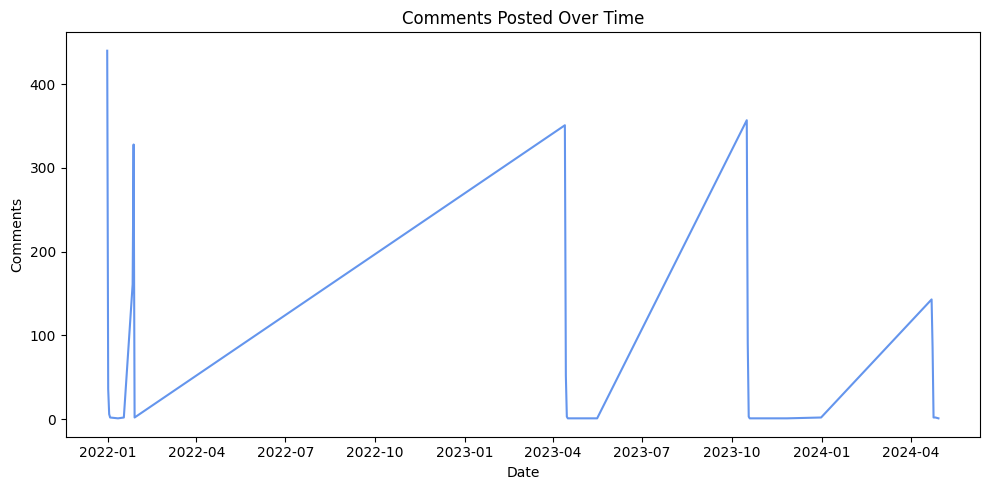

In [ ]:
ax = df.groupby(df["comment_date"].dt.date).size().plot(
    kind='line',  # or 'bar' if more appropriate for your data
    title="Comments Posted Over Time",
    ylabel="Comments",
    xlabel="Date",
    color="cornflowerblue",
    figsize=(10, 5)  # Adjust the size of the figure
)
plt.tight_layout()

In [ ]:
# print(comment_counts.index, comment_counts.values)

In [ ]:
# df.groupby(df["author"]).size().sort_values(ascending=False).iloc[0:15].plot(kind="bar", xlabel = 'Authors', ylabel="Number of comments", color ="cornflowerblue",
#       title="Comments posted by the top authors")

Data Preprocessing


In [ ]:
df['upvotes'].describe()

count    2077.000000
mean       18.058257
std        63.078231
min       -23.000000
25%         2.000000
50%         4.000000
75%        12.000000
max      1322.000000
Name: upvotes, dtype: float64

In [ ]:
df["comment_date"].min()

Timestamp('2021-12-31 00:00:00')

In [ ]:
# from nltk.stem import WordNetLemmatizer
# from nltk.tokenize import word_tokenize
# from nltk.tokenize import RegexpTokenizer

# nltk.download('wordnet')
# tokenizer = RegexpTokenizer(r'\w+')
# stop_words = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# def preprocess(row):
#     text = str(row)
#     # Convert text to lowercase
#     text = text.lower()
#     # Tokenize text
#     tokens = tokenizer.tokenize(text)
#     tokens =[token for token in tokens if token.isalpha()]
#     tokens =[token for token in tokens if token not in stop_words]
#     tokens =[lemmatizer.lemmatize(token) for token in tokens]
#     return tokens

# df['cleaned_body']=df['body'].apply(preprocess)


In [ ]:
exclusions = ['i am a bot', '[deleted]', '[redact]']
def preprocess(row):
  text = row["body"]
  if isinstance(text, str):
    text = text.lower()  # Converts to lowercase

    for excluded in exclusions:
      if excluded in text:
        return None

    text = re.sub(r'[^\w\s]', '', text) # Removes all punctuations

    keep = []

    for word in text.split():
      if word not in stopwords.words("english") and not word.startswith("@") and not word.startswith("http"):
        keep.append(word)
    return ' '.join(keep)

def logpreprocess(row):
  res = preprocess(row)
  if not res:
    print('returned None for ', row['body'])
  return res

df["cleaned_body"] = df.apply(preprocess, axis=1)
df = df.dropna(subset=['cleaned_body'])
df

,body,n_words,comment_date,upvotes,chars,cleaned_body
0,Brah…all that and you didn’t even tell us what...,13,2021-12-31,338,72,brahall didnt even tell us ice resurrection
1,"Unfortunately, there's no good way around the ...",45,2021-12-31,557,255,unfortunately theres good way around fact movi...
2,">At the time of this writing, you're kidding y...",288,2021-12-31,898,1454,time writing youre kidding think theres viable...
3,My major problem has been that I’d have no whe...,39,2021-12-31,88,200,major problem id charge dont really supercharg...
4,Great writeup! As a fellow TM3P owner (a Minus...,1644,2021-12-31,76,9209,great writeup fellow tm3p owner minus sounds l...
...,...,...,...,...,...,...
2071,FYI Honda has had a few vehicles with manual t...,148,2022-01-27,2,870,fyi honda vehicles manual transmissions also w...
2072,"I know, right? I mean, you're always going to ...",87,2022-01-27,2,482,know right mean youre always going need certai...
2074,"Joe, I totally agree...when my dad began his l...",45,2022-01-27,2,283,joe totally agreewhen dad began love mercedes ...
2075,"2.3, I’d eventually like to trade/swap my way ...",25,2022-01-27,2,124,23 id eventually like tradeswap way 1985 euro ...


In [ ]:
df

,body,n_words,comment_date,upvotes,chars,cleaned_body
0,Brah…all that and you didn’t even tell us what...,13,2021-12-31,338,72,brahall didnt even tell us ice resurrection
1,"Unfortunately, there's no good way around the ...",45,2021-12-31,557,255,unfortunately theres good way around fact movi...
2,">At the time of this writing, you're kidding y...",288,2021-12-31,898,1454,time writing youre kidding think theres viable...
3,My major problem has been that I’d have no whe...,39,2021-12-31,88,200,major problem id charge dont really supercharg...
4,Great writeup! As a fellow TM3P owner (a Minus...,1644,2021-12-31,76,9209,great writeup fellow tm3p owner minus sounds l...
...,...,...,...,...,...,...
2071,FYI Honda has had a few vehicles with manual t...,148,2022-01-27,2,870,fyi honda vehicles manual transmissions also w...
2072,"I know, right? I mean, you're always going to ...",87,2022-01-27,2,482,know right mean youre always going need certai...
2074,"Joe, I totally agree...when my dad began his l...",45,2022-01-27,2,283,joe totally agreewhen dad began love mercedes ...
2075,"2.3, I’d eventually like to trade/swap my way ...",25,2022-01-27,2,124,23 id eventually like tradeswap way 1985 euro ...


Analysis of popular words and phrases


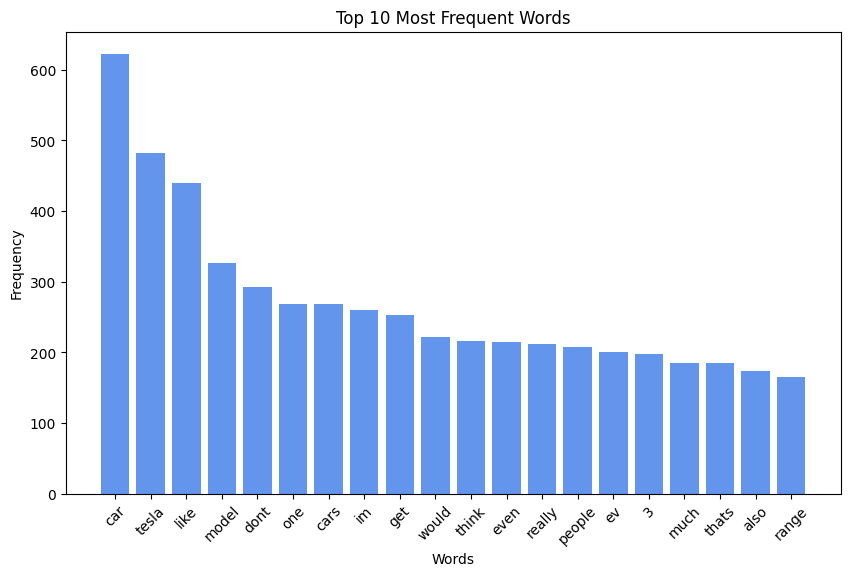

In [ ]:
word_counter = Counter()
for row in df.to_dict("records"): #converts_to_dictionary
    # Ensures that only non-None, non-empty strings are processed
    if row["cleaned_body"]:
        word_counter.update(row["cleaned_body"].split())
top_n=20
df_tf = pd.DataFrame(word_counter.most_common(top_n))
df_tf.columns = ["Word", "Frequency"]
# df_tf
%matplotlib inline

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(df_tf['Word'], df_tf['Frequency'], color='cornflowerblue')  # Create a bar chart
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_tf['Word']

0        car
1      tesla
2       like
3      model
4       dont
5        one
6       cars
7         im
8        get
9      would
10     think
11      even
12    really
13    people
14        ev
15         3
16      much
17     thats
18      also
19     range
Name: Word, dtype: object

In [ ]:
def find_common_phrases(dataframe, top_n, ngram_size):
    phrase_counter = Counter()
    # Tokenizing and counting ngrams
    for row in dataframe.to_dict("records"):
        if row["cleaned_body"]:
            tokens = word_tokenize(row["cleaned_body"])

            ngram_list = trigrams(tokens)
            ngram_list = ngrams(tokens, ngram_size)
            phrase_counter.update(ngram_list)
    most_common_phrases = phrase_counter.most_common(top_n)

    # Convert list of tuples to DataFrame
    df_phrases = pd.DataFrame(most_common_phrases, columns=["Phrase", "Frequency"])
    # Join tuple phrases for better readability
    df_phrases['Phrase'] = df_phrases['Phrase'].apply(lambda x: ' '.join(x))

    return df_phrases
df_phrases = find_common_phrases(df, top_n, ngram_size = 3)
print(df_phrases)

                        Phrase  Frequency
0          model 3 performance          8
1                tesla model 3          8
2                 10 years ago          7
3               dont get wrong          6
4            turn signal stalk          6
5      adaptive cruise control          6
6          without taking eyes          5
7             taking eyes road          5
8              people dont use          5
9                  model 3 awd          4
10                 5 years ago          4
11              miles per year          4
12              im pretty sure          4
13  acually wish manufacturers          4
14     wish manufacturers like          4
15             brand new fresh          4
16       cost cutting measures          4
17             pay 60k vehicle          4
18         60k vehicle rattles          4
19    vehicle rattles interior          4


Coocurence matrix trying

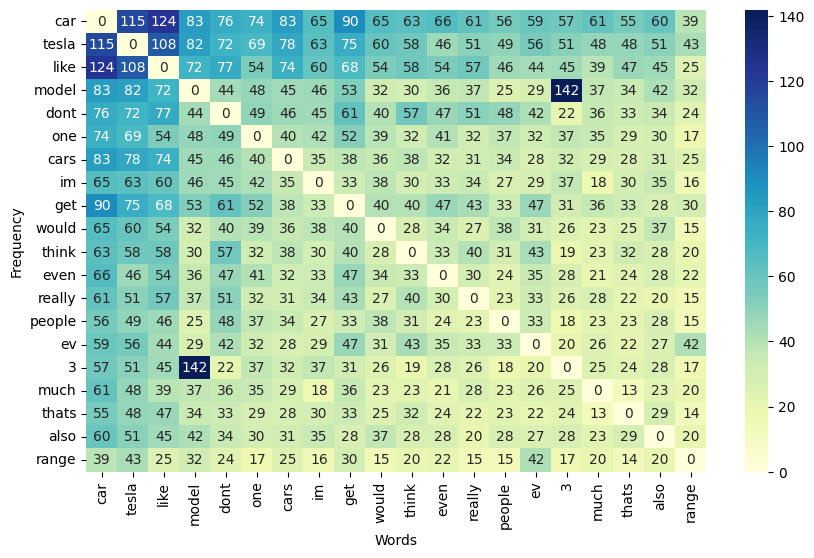

In [ ]:
import numpy as np
import seaborn as sns
matrix = np.zeros((top_n, top_n))

top_words = df_tf['Word'].tolist()  # This list should contain the top words.

for comment in df['cleaned_body']:
    words = comment.split()  # Tokenize each comment into words
    for i, word1 in enumerate(top_words):  # Correct iteration over just words
        if word1 in words:  # Check if word1 is in the list of words from the comment
            for j, word2 in enumerate(top_words):
                if i != j and word2 in words:  # Check if word2 is in the list and not the same as word1
                    matrix[i][j] += 1

plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, fmt="g", xticklabels=[word for word in top_words], yticklabels=[word for word in top_words], cmap="YlGnBu")
plt.xlabel('Words')
plt.ylabel('Frequency')
# plt.xticks(rotation=45)
plt.show()

Word correlation

In [ ]:
cloud = WordCloud(width=800, height=600)
cloud.generate_from_frequencies(dict(word_counter.most_common(500)))
image = cloud.to_image()
image.save("wordcloud.png")

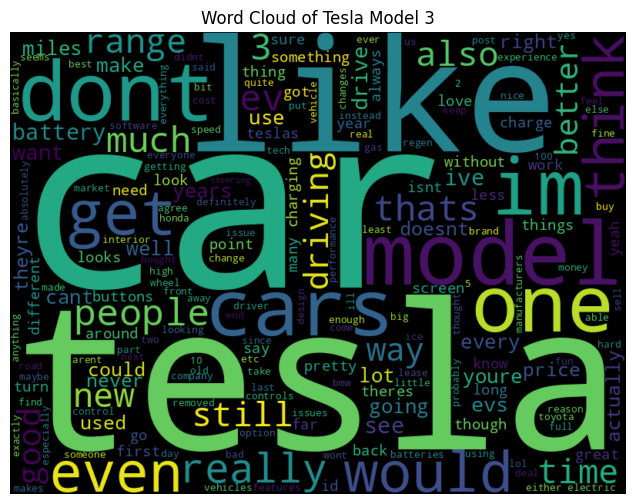

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Tesla Model 3")
plt.show()

Text Mining

Modelling and analysis of discussion themes and topics

In [ ]:
df[df["cleaned_body"].str.contains("software updates")]["cleaned_body"].size

7

In [ ]:
documents = [comment.split() for comment in df["cleaned_body"] if comment] #tokenizing_the_words
vocab = corpora.Dictionary(documents) #creating_dictionaries
corpus = [vocab.doc2bow(text) for text in documents] #converts_to_bag-of-words_format

num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=vocab, num_topics=num_topics)
lda_model

pprint(lda_model.print_topics())

[(0,
  '0.018*"car" + 0.010*"model" + 0.008*"tesla" + 0.008*"people" + 0.008*"like" '
  '+ 0.007*"dont" + 0.005*"much" + 0.005*"really" + 0.005*"cars" + '
  '0.005*"think"'),
 (1,
  '0.011*"like" + 0.010*"im" + 0.009*"cars" + 0.008*"car" + 0.007*"tesla" + '
  '0.006*"one" + 0.006*"get" + 0.005*"would" + 0.005*"driving" + 0.005*"well"'),
 (2,
  '0.011*"tesla" + 0.010*"car" + 0.008*"would" + 0.007*"dont" + 0.007*"like" + '
  '0.006*"battery" + 0.005*"one" + 0.005*"model" + 0.005*"cars" + 0.005*"3"'),
 (3,
  '0.015*"car" + 0.009*"im" + 0.007*"one" + 0.007*"tesla" + 0.005*"people" + '
  '0.005*"would" + 0.005*"thats" + 0.004*"dont" + 0.004*"ive" + 0.004*"make"'),
 (4,
  '0.007*"range" + 0.007*"tesla" + 0.006*"like" + 0.006*"miles" + 0.005*"get" '
  '+ 0.005*"model" + 0.005*"charge" + 0.005*"even" + 0.004*"dont" + 0.004*"3"'),
 (5,
  '0.011*"tesla" + 0.010*"car" + 0.010*"like" + 0.009*"im" + 0.007*"evs" + '
  '0.006*"people" + 0.006*"even" + 0.006*"dont" + 0.005*"still" + '
  '0.005*"think"

In [ ]:
topics = lda_model.print_topics(num_words=10)

for idx, topic in enumerate(topics):
    print(f"Topic #{idx+1}: {topic}")

Topic #1: (0, '0.018*"car" + 0.010*"model" + 0.008*"tesla" + 0.008*"people" + 0.008*"like" + 0.007*"dont" + 0.005*"much" + 0.005*"really" + 0.005*"cars" + 0.005*"think"')
Topic #2: (1, '0.011*"like" + 0.010*"im" + 0.009*"cars" + 0.008*"car" + 0.007*"tesla" + 0.006*"one" + 0.006*"get" + 0.005*"would" + 0.005*"driving" + 0.005*"well"')
Topic #3: (2, '0.011*"tesla" + 0.010*"car" + 0.008*"would" + 0.007*"dont" + 0.007*"like" + 0.006*"battery" + 0.005*"one" + 0.005*"model" + 0.005*"cars" + 0.005*"3"')
Topic #4: (3, '0.015*"car" + 0.009*"im" + 0.007*"one" + 0.007*"tesla" + 0.005*"people" + 0.005*"would" + 0.005*"thats" + 0.004*"dont" + 0.004*"ive" + 0.004*"make"')
Topic #5: (4, '0.007*"range" + 0.007*"tesla" + 0.006*"like" + 0.006*"miles" + 0.005*"get" + 0.005*"model" + 0.005*"charge" + 0.005*"even" + 0.004*"dont" + 0.004*"3"')
Topic #6: (5, '0.011*"tesla" + 0.010*"car" + 0.010*"like" + 0.009*"im" + 0.007*"evs" + 0.006*"people" + 0.006*"even" + 0.006*"dont" + 0.005*"still" + 0.005*"think"')


In [ ]:
# !pip install pyLDAvis

# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis

# # Prepare visualization for the LDA model
# pyLDAvis.enable_notebook()
# vis = gensimvis.prepare(lda_model, corpus, vocab)
# pyLDAvis.display(vis)

Sentiment Analysis

In [ ]:
# Sentiment Analysis
df['polarity'] = df['cleaned_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

def categorize_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['polarity'].apply(categorize_sentiment)

In [ ]:
df['sentiment'].value_counts()

sentiment
Positive    1072
Neutral      463
Negative     446
Name: count, dtype: int64

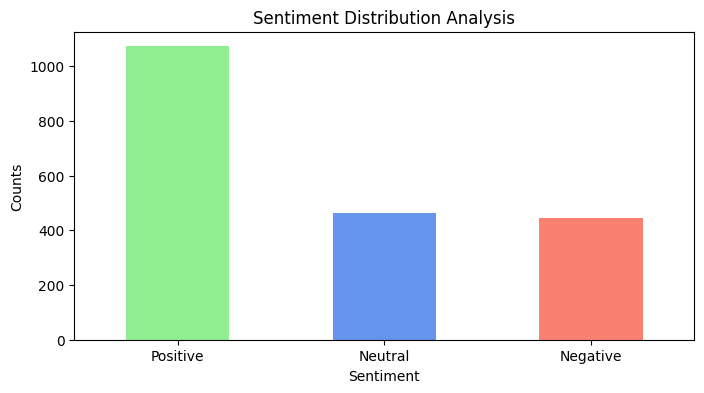

In [ ]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 4))
sentiment_counts.plot(kind='bar', color=['lightgreen', 'cornflowerblue', 'salmon'])
plt.title('Sentiment Distribution Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# nltk.download("vader_lexicon")
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# sia = SentimentIntensityAnalyzer()
# def score_vader(row):
#   text = row["cleaned_body"]
#   return sia.polarity_scores(text)["compound"]

# df["vader_sentiment_po"] = df.apply(score_vader, axis=1)

In [ ]:
# def categorize_vader_sentiment(polarity):
#     if polarity > 0:
#         return 'Positive'
#     elif polarity < 0:
#         return 'Negative'
#     else:
#         return 'Neutral'

# df['vader_sentiment'] = df['vader_sentiment_po'].apply(categorize_vader_sentiment)

In [ ]:
# df['vader_sentiment'].value_counts()

In [ ]:
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=documents, dictionary=vocab, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_lda}")

Coherence Score: 0.5152967358636602


In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Perplexity:  -8.596374506890006


In [ ]:
import pandas as pd

def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Append row to dataframe
                temp_df = pd.DataFrame([int(topic_num), round(prop_topic,4), topic_keywords]).T
                temp_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
                sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename('Text')], axis=1)
    return sent_topics_df

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['cleaned_body'])
# If merging back to the main DataFrame, ensure matching column names:
df = pd.merge(df, df_topic_sents_keywords, left_index=True, right_index=True)
# Check column names
print(df.columns)

Index(['body', 'n_words', 'comment_date', 'upvotes', 'chars', 'cleaned_body',
       'polarity', 'sentiment', 'Dominant_Topic_x', 'Perc_Contribution_x',
       'Topic_Keywords_x', 'Text_x', 'Dominant_Topic_y', 'Perc_Contribution_y',
       'Topic_Keywords_y', 'Text_y'],
      dtype='object')


In [ ]:
# Accessing the dominant topic column
if 'Dominant_Topic' in df.columns:
    topic_counts = df['Dominant_Topic'].value_counts()
else:
    print("Column 'Dominant_Topic' does not exist in the DataFrame.")

Column 'Dominant_Topic' does not exist in the DataFrame.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Topics visualization
topic_counts = df['Dominant_Topic'].value_counts()
sns.barplot(x=topic_counts.index, y=topic_counts.values, color='cornflowerblue')
plt.title('Frequency of Topics Among Reviews')
plt.xlabel('Topics')
plt.ylabel('Number of Comments')
plt.show()

KeyError: 'Dominant_Topic'

In [ ]:
df

In [ ]:
df["polarity"].plot(kind="hist", color="cornflowerblue",
                         title="Frequency distribution of normalised sentiment score")